<a href="https://colab.research.google.com/github/paultgriffiths/colab_notes/blob/main/EOFS_KMEANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install eofs

!pip install xarray
!pip install netcdf4
#!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

     |████████████████████████████████| 4.7MB 12.4MB/s 
     |████████████████████████████████| 317kB 49.5MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759562 sha256=8145daaa00f63a0ec9713c9912268f750caba6dc60150123ad51275650e4c30d
  Stored in directory: /tmp/pip-ephem-wheel-cache-zt3mibxd/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


In [2]:

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

from eofs.xarray import Eof
from eofs.examples import example_data_path



In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc
#from IPython.display import HTML, Image # For GIF
#xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import datetime
from mpl_toolkits.basemap import Basemap

In [4]:

#!pip install zarr gcsfs 
import zarr
import gcsfs


In [ ]:

def roll_longitude(data):
    lon_name = 'lon'  # whatever name is in the data
    # Adjust lon values to make sure they are within (-180, 180)
    data['_longitude_adjusted'] = xr.where(
    data[lon_name] > 180,
    data[lon_name] - 360,
    data[lon_name])

    # reassign the new coords to as the main lon coords
    # and sort DataArray using new coordinate values
    data = (
        data
        .swap_dims({lon_name: '_longitude_adjusted'})
        .sel(**{'_longitude_adjusted': sorted(data._longitude_adjusted)})
        .drop(lon_name))
    data = data.rename({'_longitude_adjusted': lon_name})
    return data


In [95]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
# df_psl_day = df.query("institution_id == 'NCAR' & source_id=='CESM2' & member_id=='r1i1p1f1' & activity_id=='CMIP' & table_id == 'daily' & variable_id == 'psl' & experiment_id == 'historical'")
# df_psl_day = df.query("institution_id == 'NCAR' & source_id=='CESM2' & member_id=='r1i1p1f1' & activity_id=='CMIP' & table_id == 'day' & variable_id == 'psl' & experiment_id == 'historical'")
df_psl_day = df.query("institution_id == 'NCAR'& activity_id=='CMIP' & experiment_id=='historical' & source_id=='CESM2-WACCM'  & table_id == 'Amon' & variable_id == 'zg'  & member_id=='r2i1p1f1'")
#df_psl_day


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
54878,CMIP,NCAR,CESM2-WACCM,historical,r2i1p1f1,Amon,zg,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227


In [96]:
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_psl_day.zstore.values[-1]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

In [99]:
ds = xr.open_zarr(mapper, consolidated=True)# if you get a cftime error, means you're missing netcdf4
ds = roll_longitude(ds)
# Read geopotential height data using the xarray module. The file contains
# December-February averages of geopotential height at 500 hPa for the
# European/Atlantic domain (80W-40E, 20-90N).
ds = ds.sel(time=ds.time.dt.season=="DJF")
ds = ds.sel({"plev":5e4})
ds = ds.sel(lat = slice(20,90), lon=slice(-80,40))

In [132]:

z_djf = ds.zg.copy()
vec1 = np.zeros([100, 97*75])
coslat = np.cos(np.deg2rad(z_djf.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]

for i in range(0,10):
    print(i)
    z_djf = ds.zg.copy()
    z_djf = z_djf[i*3:(i+1)*3,:,:]
    # Compute anomalies by removing the time-mean.
    z_djf = z_djf - ds.zg.mean(dim='time')
    # Create an EOF solver to do the EOF analysis. Square-root of cosine of
    # latitude weights are applied before the computation of EOFs.
    solver = Eof(z_djf, weights=wgts)
    # Retrieve the leading EOF, expressed as the covariance between the leading PC
    # time series and the input SLP anomalies at each grid point.
    eof1 = solver.eofsAsCovariance(neofs=1)
    vec1[i,:] = eof1[:,:].squeeze().values.reshape(97*75)


0
1
2
3
4
5
6
7
8
9


In [136]:

np.save('vec1.npy',vec1)

In [137]:
vec1[0,:]

array([-18.50123596, -18.46138763, -17.72045517, ...,  -6.58995914,
        -6.58967638,  -6.58983135])

Text(0.5, 1.0, 'EOF1 expressed as covariance')

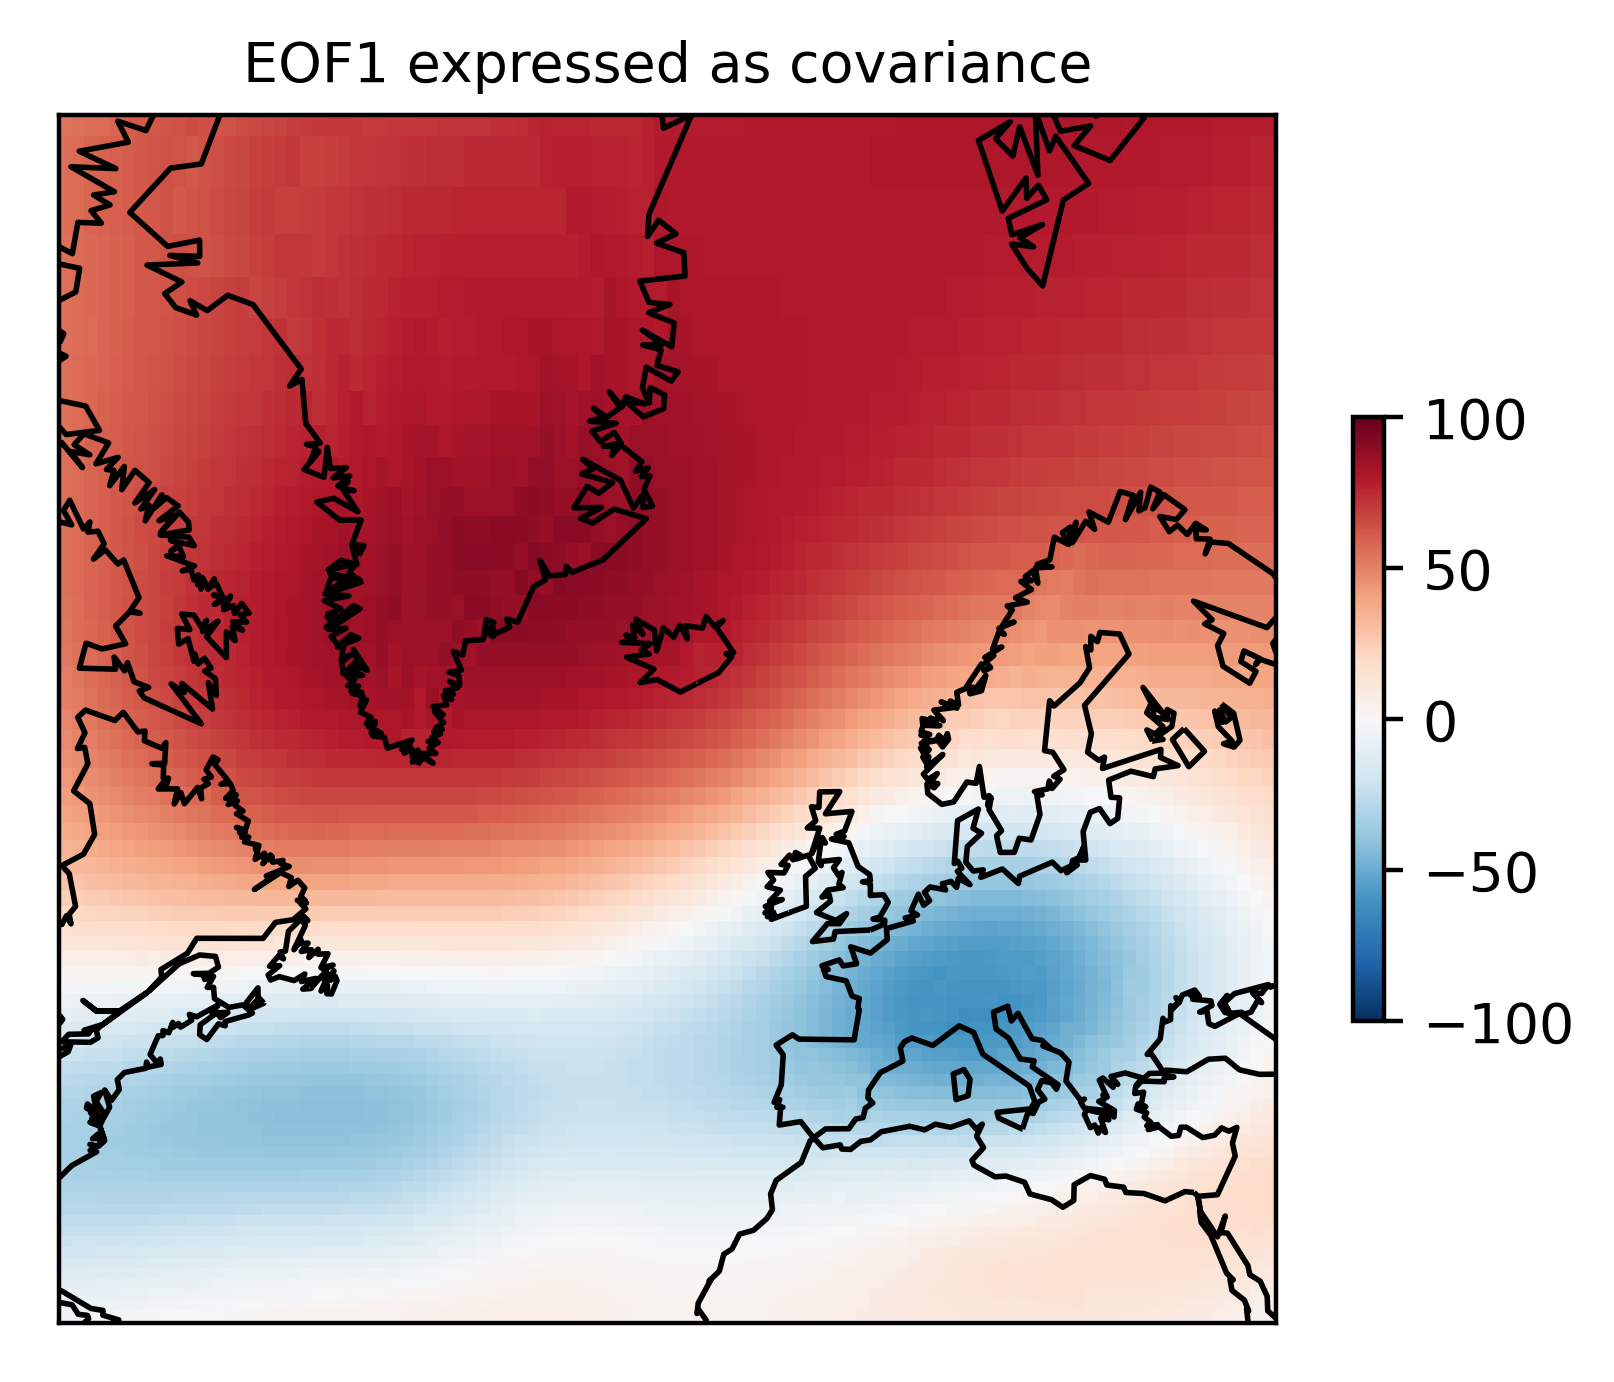

In [115]:
# Plot the leading EOF expressed as covariance in the European/Atlantic domain.

fig=plt.figure(figsize=(5,4), dpi=200.)
ax=plt.subplot(1,1,1)
map = Basemap(projection='merc',llcrnrlat=20,urcrnrlat=80,\
            llcrnrlon=-80,urcrnrlon=40,lat_ts=20,resolution='c')
map.drawcoastlines()
#We need to prime the pump, so to speak and create a quadmesh for plt to work with
#a = ds.psl[0,:,:].squeeze().data
lon=np.array(eof1.lon.values)
lat=np.array(eof1.lat.values)
X,Y = np.meshgrid(lon, lat) 
cs1 = map.pcolormesh(X,Y, data=eof1[0,:,:], latlon = True, vmin=-100., vmax=100.,cmap ='RdBu_r')#, shading='gouraud')# transform=ccrs.PlateCarree())
plt.colorbar(shrink=0.5)
ax.set_title('EOF1 expressed as covariance', fontsize=10)

Text(0.5, 1.0, 'EOF1 expressed as covariance')

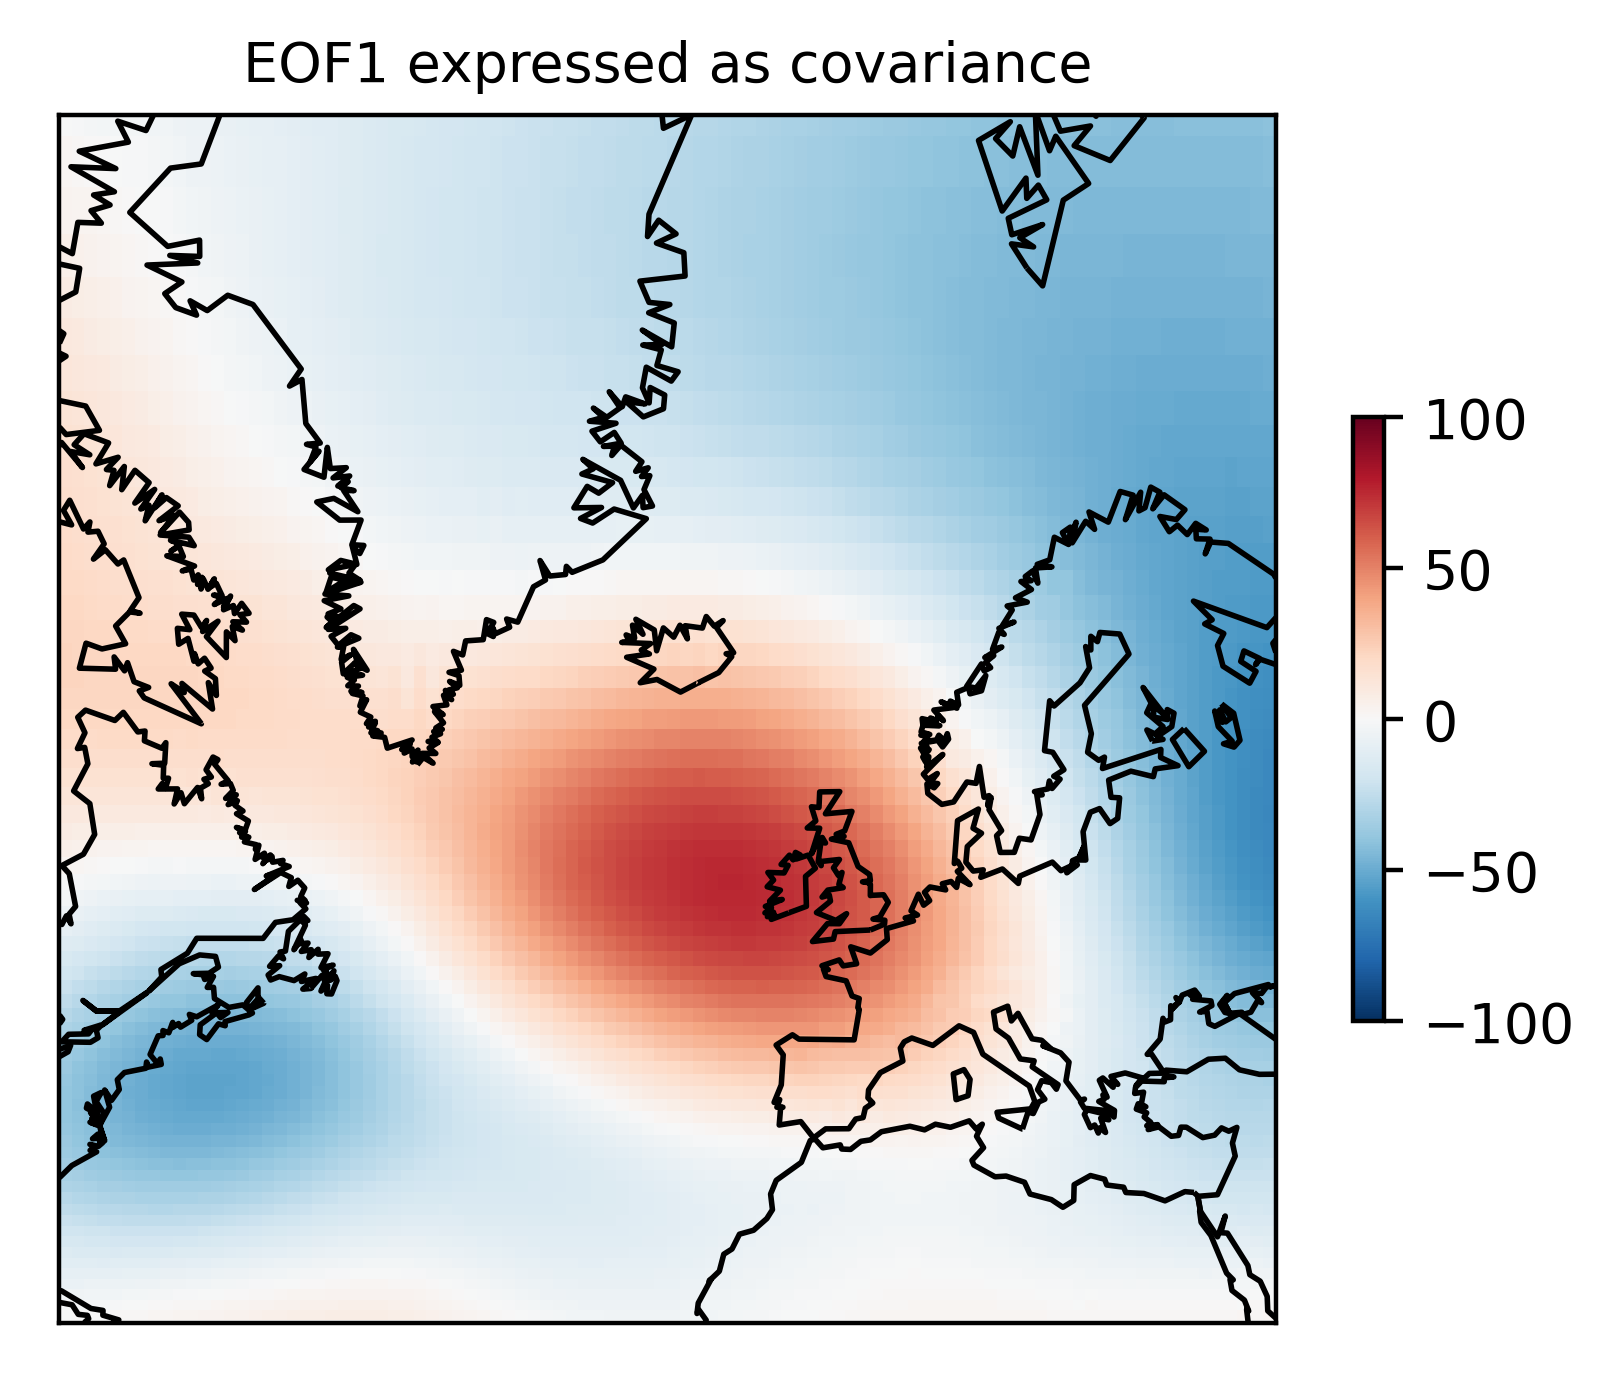

In [116]:

fig=plt.figure(figsize=(5,4), dpi=200.)
ax=plt.subplot(1,1,1)
map = Basemap(projection='merc',llcrnrlat=20,urcrnrlat=80,\
            llcrnrlon=-80,urcrnrlon=40,lat_ts=20,resolution='c')
map.drawcoastlines()
#We need to prime the pump, so to speak and create a quadmesh for plt to work with
#a = ds.psl[0,:,:].squeeze().data
lon=np.array(eof1.lon.values)
lat=np.array(eof1.lat.values)
X,Y = np.meshgrid(lon, lat) 
cs1 = map.pcolormesh(X,Y, data=eof1[1,:,:], latlon = True, vmin=-100., vmax=100.,cmap ='RdBu_r')#, shading='gouraud')# transform=ccrs.PlateCarree())
plt.colorbar(shrink=0.5)
ax.set_title('EOF2 expressed as covariance', fontsize=10)

Text(0.5, 1.0, 'EOF3 expressed as covariance')

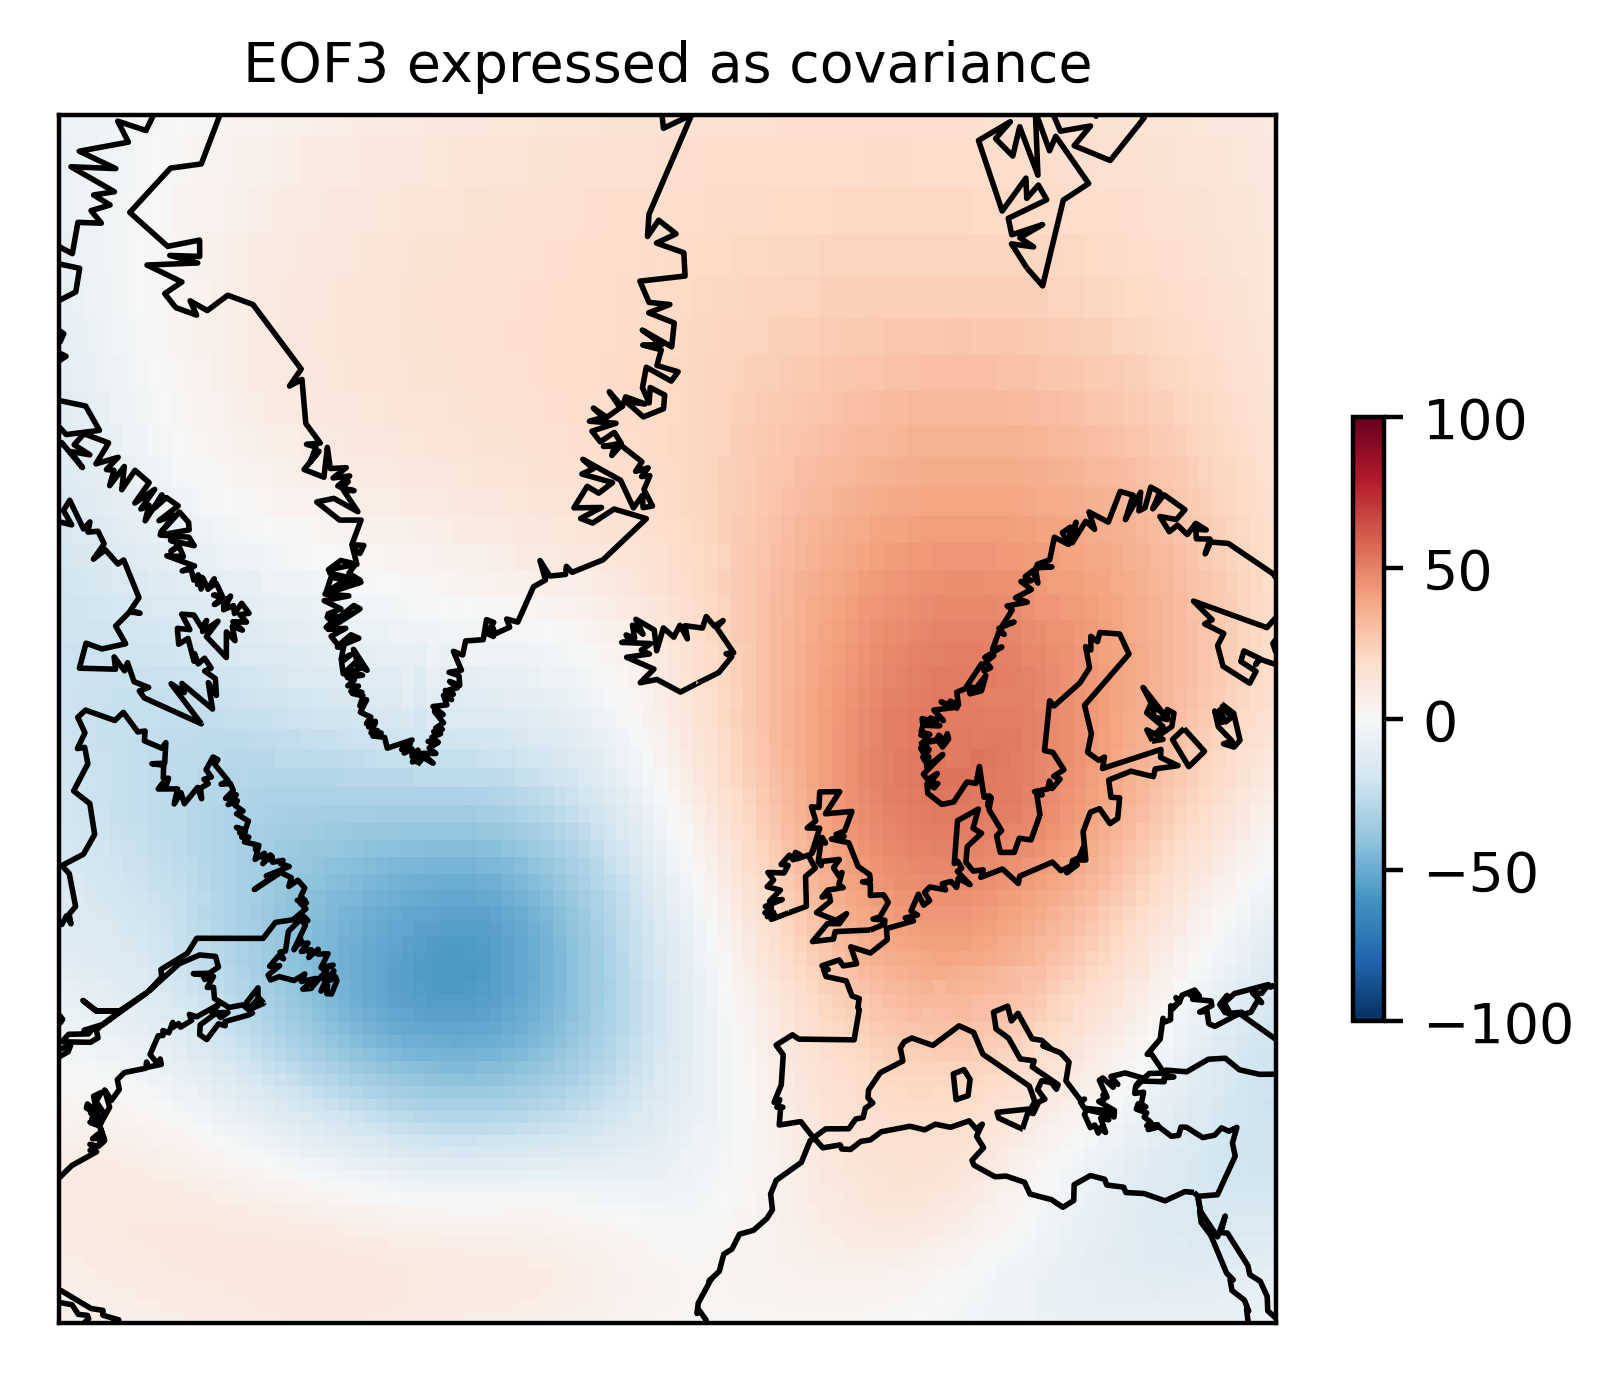

In [117]:

fig=plt.figure(figsize=(5,4), dpi=200.)
ax=plt.subplot(1,1,1)
map = Basemap(projection='merc',llcrnrlat=20,urcrnrlat=80,\
            llcrnrlon=-80,urcrnrlon=40,lat_ts=20,resolution='c')
map.drawcoastlines()
#We need to prime the pump, so to speak and create a quadmesh for plt to work with
#a = ds.psl[0,:,:].squeeze().data
lon=np.array(eof1.lon.values)
lat=np.array(eof1.lat.values)
X,Y = np.meshgrid(lon, lat) 
cs1 = map.pcolormesh(X,Y, data=eof1[2,:,:], latlon = True, vmin=-100., vmax=100.,cmap ='RdBu_r')#, shading='gouraud')# transform=ccrs.PlateCarree())
plt.colorbar(shrink=0.5)
ax.set_title('EOF3 expressed as covariance', fontsize=10)

In [110]:
pc1 = solver.pcs(npcs=1, pcscaling=1)

Text(0.5, 1.0, 'PC1 Time Series')

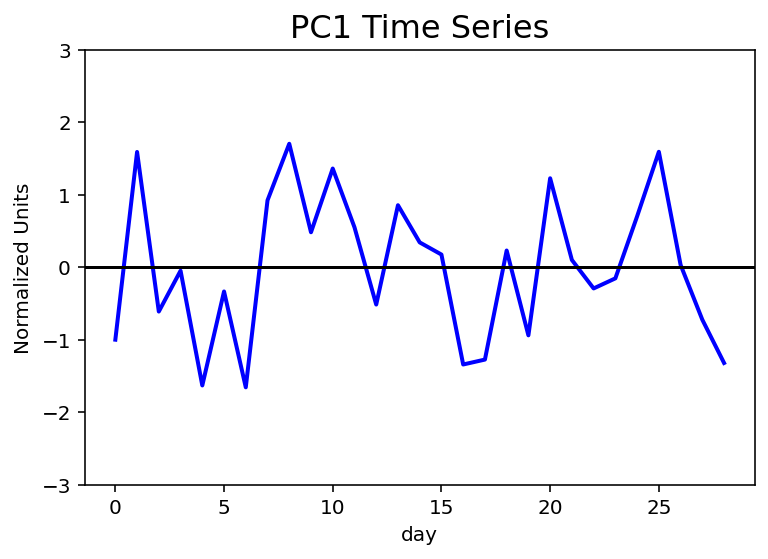

In [111]:
# Plot the leading PC time series.
plt.figure()
plt.plot(pc1[:, 0],color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('day')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)